In [1]:
%%javascript
$(document).ready(() => {
    // Удаление данного блока кода с конечного результата.
    $('div.code_cell').first().css('display', 'none');

    // Включение автоматического переноса слов в параграфе.
    $('div.text_cell p').css('hyphens', 'auto');

    // Включение растягивания текста на всю доступную длину.
    $('div.text_cell p').css('text-align', 'justify');
});

<IPython.core.display.Javascript object>

<h3><b>Лабораторная работа №6: Кластеризация</b></h3>

<p lang="ru">Кластеризация — это задача группировки множества объектов на подмножества, называемые кластерами. Внутри каждой группы должны оказаться «похожие» объекты, а объекты разных группы должны быть как можно более различны. Главное отличие кластеризации от классификации состоит в том, что перечень групп четко не задан и определяется в процессе работы алгоритма.</p>

In [2]:
%autosave 300

Autosaving every 300 seconds


In [3]:
import warnings

# Игнорирование некоторых оповещающих сообщений библиотек.
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
import collections
import copy

In [5]:
import numpy as np

In [6]:
# Импортирование функции для чтения MATLAB файлов.
from scipy.io import loadmat

In [7]:
# Импортирование алгоритма иерархической кластеризации.
from sklearn.cluster import AgglomerativeClustering

In [8]:
# Импортирование библиотеки для работы с графиками.
from matplotlib import pyplot
%matplotlib inline

In [9]:
# Установка начального значения для генератора случайных чисел.
# Данное действие требуется для воспроизведения результатов опыта.
np.random.seed(0)

<p lang="ru"><b>Пункт №1:&nbsp;</b>Загрузка первого предоставленного набора данных <tt>ex6data1.mat</tt> при помощи внешней библиотеки scipy. Текущий набор данных содержит информацию о координатах двух точек, которые необходимо кластеризовать.</p>

In [10]:
data = loadmat('./datasets/ex6data1.mat')['X']

<p lang="ru"><b>Пункт №2:&nbsp;</b>Реализация функции инициализации с модификацией k-means++ для выбора центров кластеров. Суть улучшения заключается в нахождении более оптимальных начальных значений центроидов кластеров. Оригинальный k-means не регламентирует то, как выполняется этот этап алгоритма, и поэтому является нестабильным.</p>

In [11]:
def calc_centroids(x, k=5):
    index = np.random.randint(0, x.shape[0])

    # Инициализация первого центроида из точек данных.
    centroids = np.array([x[index]])

    for _ in range(1, k):
        # Вычисление расстояний от выбронного центроида до всех точек данных.
        dist = [np.min(np.square(i - centroids)) for i in x]

        # Вычисление распределения вероятностей выбора следующего центроида.
        probs = np.cumsum(dist / np.sum(dist))

        # Вычисление индекса по вероятности следующего центроида.
        index = np.argmax(probs > np.random.rand())

        # Добавление вычисленного центроида в результирующую матрицу.
        centroids = np.append(centroids, [x[index]], axis=0)

    return centroids

<p lang="ru"><b>Пункт №3:&nbsp;</b>Реализация функции определения принадлежности значения к кластеру. Данная функция вычисляет минимальное евклидово расстояние от заданной точкой данных до оптимального центроида алгоритма.</p>

In [12]:
def calc_pred(centroids, x):
    # Функция вычисления принадлежности значения к кластеру.
    return np.argmin(np.linalg.norm(x - centroids, axis=1))

<p lang="ru"><b>Пункт №4:&nbsp;</b>Реализация функции пересчета центров кластеров. Основная идея заключается в том, что на каждой итерации перевычисляется центр масс для каждого кластера, полученного на предыдущем шаге, затем векторы разбиваются на кластеры вновь в соответствии с тем, какой из новых центров оказался ближе по выбранной метрике. Алгоритм завершается, когда на какой-то итерации не происходит изменения внутрикластерного расстояния. Это происходит за конечное число итераций, так как количество возможных разбиений конечного множества конечно.</p>

In [13]:
# Количество кластеров.
kernels = 4

In [14]:
def calc_kmeans(x, k=5):
    # Контейнер для истории значений центроидов.
    records = collections.defaultdict(list)

    # Вычисление начальных координат центроидов.
    centroids = calc_centroids(x, k)

    # Сохраняем старые значения центроидов для обновления.
    centroids_old = np.zeros(centroids.shape)

    # Создание контейнера для индексов кластеров.
    indexes = np.zeros(x.shape[0])

    # Создание контейнера для значений кластеров.
    output = {}

    # Запуск минимизации ошибки между значениями центроидов. 
    while np.linalg.norm(centroids - centroids_old):
        for i in range(x.shape[0]):
            # Вычисление евклидовых расстояний для всех точек данных.
            dist = np.linalg.norm(x[i] - centroids, axis=1)

            # Поиск значений минимальных расстояний до центров.
            indexes[i] = np.argmin(dist, axis=0)

        # Сохраняем значения центроидов перед обновлением.
        centroids_old = copy.deepcopy(centroids)

        for i in range(k):
            # Сохраняем значения координат центроидов.
            records[i].append(centroids[i].tolist())

            # Вычисление значений входящик в кластер.
            output[i] = x[indexes == i]

            # Обновление координат центроида.
            centroids[i] = np.mean(output[i], axis=0)

    return output, indexes, centroids, records

In [15]:
%%time

# Запуск оптимизации математической модели.
output, indexes, centroids, records = calc_kmeans(data, kernels)

CPU times: user 54.4 ms, sys: 10.9 ms, total: 65.3 ms
Wall time: 55.7 ms


<p lang="ru"><b>Пункт №5:&nbsp;</b>Построение графика зависимости первой переменной от второй. Всякую зависимость между двумя типами данных хорошо показывает диаграмма разброса значений. Ко всему прочему, с помощью этой диаграммы можно определить корреляцию между каким-либо параметром качества и влияющим на него фактором. Помимо этого на графике показаны кластеры, полученные после обучения математической модели.</p>

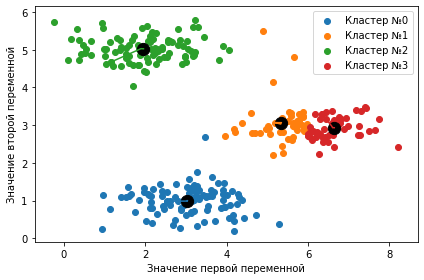

In [16]:
for i in range(kernels):
    # Построение рассматриваемого кластера данных.
    pyplot.scatter(output[i][:, 0], output[i][:, 1], label='Кластер №{}'.format(i))

    # Построение траектории движения центроида.
    pyplot.plot(np.array(records[i])[:, 0], np.array(records[i])[:, 1])

    # Построение положения центроида рассматриваемого кластера данных.
    pyplot.scatter(centroids[i][0], centroids[i][1], c='k', s=150)

# Настройка координатных осей графика.
pyplot.xlabel('Значение первой переменной')
pyplot.ylabel('Значение второй переменной')

# Построение легенды графика.
pyplot.legend(loc='best')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

In [17]:
# Поиск оптимального количества центров методом elbow.
wcss_array = np.array([])

for k in range(1, 11):
    # Запуск оптимизации математической модели.
    output, indexes, clusters, records = calc_kmeans(data, k)

    wcss = np.sum([
        # Вычисление евклидового расстояния для рассматриваемой точки данных.
        np.sum(np.square(output[i] - clusters[i])) for i in range(k)
    ])

    wcss_array = np.append(wcss_array, wcss)

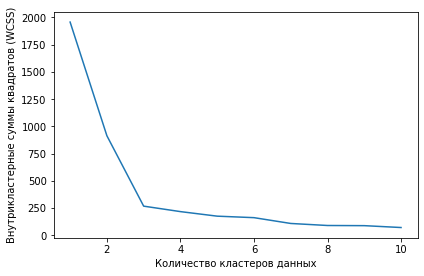

In [18]:
# Построение графика линии elbow метода.
pyplot.plot(np.arange(1, 11), wcss_array)

# Настройка координатных осей графика.
pyplot.xlabel('Количество кластеров данных')
pyplot.ylabel('Внутрикластерные суммы квадратов (WCSS)')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

***

<p lang="ru"><b>Пункт №6:&nbsp;</b>Загрузка второго предоставленного набора данных <tt>bird_small.mat</tt> при помощи внешней библиотеки scipy. Текущий набор данных содержит одно изображение в оттенках серого. Каждый пиксель представляет собой значение яркости.</p>

In [19]:
data = loadmat('./datasets/bird_small.mat')['A']

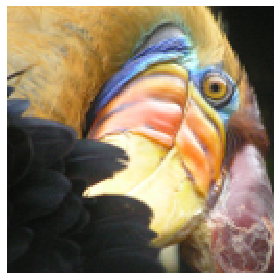

In [20]:
# Визуализация оригинального изображения.
pyplot.imshow(data)

# Отключение координатных осей.
pyplot.axis('off')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

<p lang="ru"><b>Пункт №7:&nbsp;</b>Применение алгоритма k-means++ с заданым количеством кластеров для предоставленного избражения. В результате обучения математической модели можно заметить, что качество изображения стало немного хуже и вес самой картинки стал тоже меньше.</p>

In [21]:
def prepare_image(img):
    # Преобразование тензора изображения в 2D матрицу.
    return np.reshape(img / 255.0, newshape=(-1, 3))

In [22]:
# Подготовка изображения.
img = prepare_image(data)

In [23]:
%%time

# Запуск оптимизации математической модели.
output, indexes, centroids, records = calc_kmeans(img, 16)

CPU times: user 38 s, sys: 504 ms, total: 38.5 s
Wall time: 39.3 s


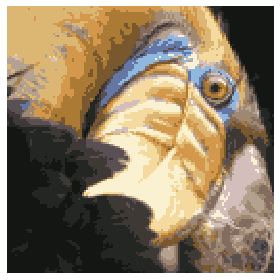

In [24]:
# Визуализация результата после обучения математической модели.
pyplot.imshow(centroids[indexes.astype(int)].reshape(data.shape))

# Отключение координатных осей.
pyplot.axis('off')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

***

<p lang="ru"><b>Пункт №8:&nbsp;</b>Применение алгоритма k-means++ с заданым количеством кластеров для другого предоставленного избражения. Как и в предыдущем пункте качество изображения стало немного хуже и вес самой картинки стал тоже меньше. Следовательно, можно сделать вывод о том, что данный алгоритм можно использовать для сжатия изображений.</p>

In [25]:
data = loadmat('./datasets/img_small.mat')['A']

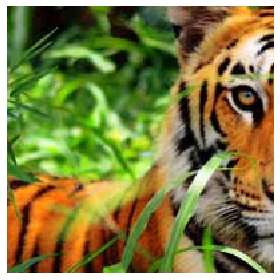

In [26]:
# Визуализация оригинального изображения.
pyplot.imshow(data)

# Отключение координатных осей.
pyplot.axis('off')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

In [27]:
# Подготовка изображения.
img = prepare_image(data)

In [28]:
%%time

# Запуск оптимизации математической модели.
output, indexes, centroids, records = calc_kmeans(img, 16)

CPU times: user 1min 12s, sys: 819 ms, total: 1min 13s
Wall time: 1min 16s


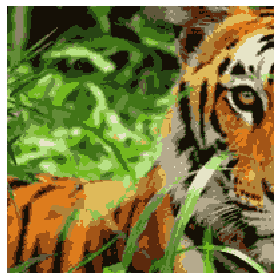

In [29]:
# Визуализация результата после обучения математической модели.
pyplot.imshow(centroids[indexes.astype(int)].reshape(data.shape))

# Отключение координатных осей.
pyplot.axis('off')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

<p lang="ru"><b>Пункт №9:&nbsp;</b>Применение алгоритма иерархической кластеризации с заданым количеством кластеров для другого предоставленного избражения. Сравнив результаты рассмотренных алгоритмов клатеризации можно сделать вывод, что они отработали одинаково и пригодны для сжатия изображений.</p>

In [30]:
%%time

# Запуск оптимизации математической модели.
indexes = AgglomerativeClustering(n_clusters=16).fit_predict(img)

CPU times: user 1min 31s, sys: 16.9 s, total: 1min 48s
Wall time: 2min 6s


In [31]:
# Распределение значений пикселей по кластерам.
output = collections.defaultdict(list)
for num, index in enumerate(indexes):
    output[index].append(img[num].tolist())

# Вычисление центроидов кластеров.
clusters = []
for index in sorted(output):
    clusters.append(np.mean(output[index], axis=0).tolist())

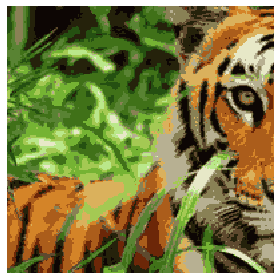

In [32]:
# Визуализация результата после обучения математической модели.
pyplot.imshow(np.array(clusters)[indexes].reshape(data.shape))

# Отключение координатных осей.
pyplot.axis('off')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()